## ExperiWatt - Gehirn und Energie
In diesem Arbeitsblatt lernt ihr eigenständig eine vollständige Bearbeitung, Visualisierung und Analyse von euren eigenen EEG Daten durchzuführen. Dafür benötigen wir einige Funktionen des Python Softwarepackages MNE. In dem Dokument **"MNE Funktionen"** findet ihr eine Liste an Funktionen die ihr dafür braucht.
Die orangen "Todo" Zellen geben an, wenn ihr den Code selber bearbeiten sollt. Drei `...` geben euch einen Tipp wo ihr eigene Werte einsetzen müsst. An der Punkteanzahl die ihr für jede Aufgabe bekommt könnt ihr den Schwierigkeitsgrad der Aufgabe abschätzen. Wichtig: Führt alle Code-Zellen aus (Str+Entr Tastenkombination), auch wenn kein "Todo" darüber steht. 


Übersicht:
1) EEG Daten laden

2) Elektroden Montage Mapping 

3) Daten Betrachtung

4) Frequenz Stärken Spektrum

5) Preprocessing (Säubern der Daten)

6) EEG Topography

7) Berechnung der Energie im aktiven und passiven Zustand


In [1]:
# zunächst importieren wir das MNE Package & weitere Packages, damit wir sie verwenden können
import logging
logging.getLogger('numexpr').setLevel(logging.WARNING)
import warnings
# Suppress specific UserWarnings about non-interactive FigureCanvasAgg
warnings.filterwarnings('ignore', category=UserWarning, message='.*FigureCanvasAgg is non-interactive.*')
import mne 
from mne import viz
from mne.io import RawArray
from mne.preprocessing import ICA
from mne_icalabel import label_components
from pyprep.find_noisy_channels import find_bad_by_ransac
import matplotlib.pyplot as plt
import numpy as np
from meegkit.detrend import detrend
from meegkit.dss import dss_line
import pandas as pd
from helper_functions import *
mne.set_log_level('ERROR')

### 1) EEG Daten laden
Um unsere Daten einsehen zu können müssen wir sie aus unserem Ordner wo wir sie gespeichert haben hier in unser Programm laden.

<div class='alert alert-warning'>
<b>ToDo</b> (1 Punkt): Ersetze die '...' durch den Namen der EEG Aufzeichnungsdatei (Tipp: die Endung '.vhdr' muss ebenfalls ausgeschrieben werden). 
</div>

In [2]:
# Name der Datei
fdir = 'Experiment/output_data/'
fname = 'Test_Ole_2024-02-27_15-02-52.vhdr'

# Lade die Datei. In MNE werden EEG Datensätze im "Raw" format gespeichert.
raw = mne.io.read_raw_brainvision(fdir+fname, preload=True)

### 2) Elektroden Montage Mapping
Das Softwarepackage MNE ermöglicht es uns mit einer standardisierten Map die EEG Aktivität auf die richtige Stelle auf dem Kopf zu projezieren. Die folgende Abbildung zeigt wie die Montage für das EEG System aussehen sollte.
Die Standardmontage heißt `standard_1020`.
<br>
<br>

<div>
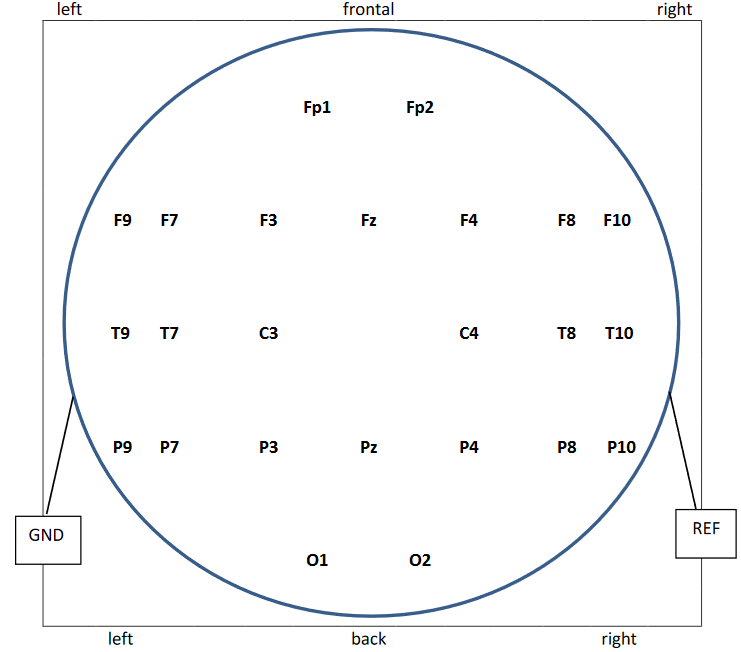
</div>

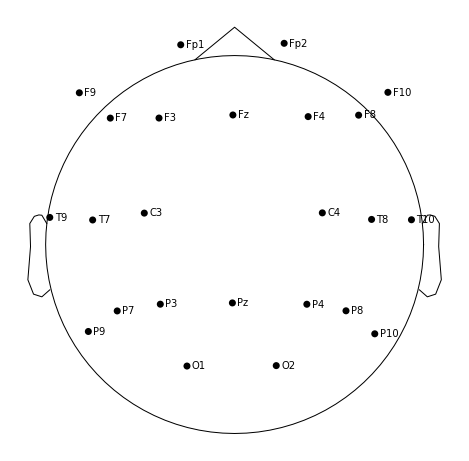

In [3]:
# Standard Map laden und an Datensatz zufügen
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
fig = raw.plot_sensors(show_names=True)

In [4]:
# Elektrodennummerierung
channels = pd.read_csv('electrode_info.csv')
channels = channels[1:25].reset_index()['electrodes']
channel_names = pd.DataFrame(channels, index=range(24))
channel_names['ID'] = range(24)
channel_names

,electrodes,ID
0,Fp1,0
1,Fp2,1
2,F9,2
3,F7,3
4,F3,4
5,Fz,5
6,F4,6
7,F8,7
8,F10,8
9,T9,9


### 2) Daten Betrachtung
Jetzt können wir einen ersten Blick auf die Daten werfen!

<div class='alert alert-warning'>
    <b>ToDo</b> (1 Punkt): Erstelle eine Abbildung der EEG Daten. Verwende dazu die mne function <tt>plot_signal()</tt>, welche als Parameter das Datenset (<tt>raw</tt>), eine Startzeit und Endzeit (in Sekunden), sowie Elektrodennummer(n) annimmt. 
    Beispiel:  <tt>plot_signal(raw, start=20, end=600, electrodes=[5, 21])</tt>. Betrachtet die ganze Länge der Daten, und notiert euch Elektroden, die stark flukuturieren oder starke Störungen aufweisen.
</div>

<div class='alert alert-success'>
    <b>Tipp</b>: Die Elektroden sind durchnummeriert. In der obigen Tabelle im Abschnitt "Elektroden Montage Mapping" könnt ihr sehen welche ID zu welcher Elektrode gehört. Diese könnt ihr dann fpr den Parameter <tt>electrodes</tt> in der Funktion <tt>plot_signal()</tt> eingeben. Beispiel: Um die Elektrode F4 und P3 darstellen zu lassen gebe ich die IDs 6 und 17 ein (<tt>electrodes=[6, 17]</tt>). Mit dem Befehl <tt>range(24)</tt> (anstelle der eckigen Klammern) könnt ihr alle 24 Elektroden zugleich abbilden. 
</div>

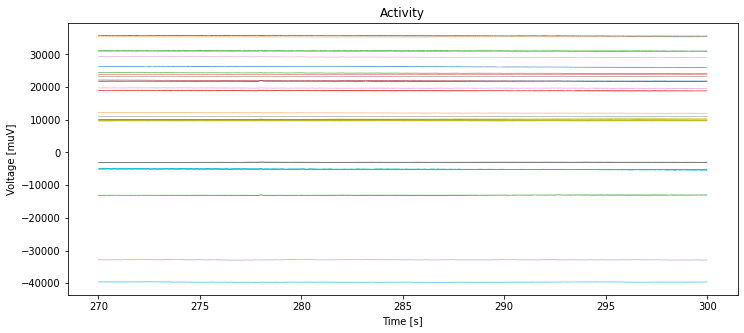

In [5]:
plot_signal(raw, start=270, end=300, electrodes=range(24))

Falls ihr eine Elektrode (oder mehrere) entdeckt die stark fluktuiert, notiert sie euch. Kanäle mit sehr schlechten Signal werden wir in einem späteren Schritt entfernen.

### 4) Frequenz Power Spektrum
EEG Daten sind aus Wellen verschiedener Frequenzen zusammengesetzt, da Neuronen in unserem Gehirn unterschiedlich schnelle Signale senden und miteinander kommunizieren. Jede Frequenz trägt unterschiedlich viel zur gesamten Leistung der Gehirnaktivität bei. Ihr habt bereits gelernt, dass die **Fourier Transformation** angewendet werden kann um die Amplitude jeder Frequenz des EEG Signals herauszufinden. Der resultierende Graph wird auch Power Spektrum genannt.

In diesem Aufgabenteil wollen wir herausfinden welche Frequenzen in unseren EEG Daten vorhanden sind, und wie stark jede Frequenz vertreten ist. 
Mit Hilfe der sogenannten Fourier Analyse ist es möglich die Amplituden (auch Power spectrum density genannt) jeder Frequenz des EEG Signals herauszufinden. Der resultierende Graph wird auch Power Spektrum genannt.

In der folgenden Abbildung seht ihr wie ein typisches EEG Spektrum von gereinigten Daten (und im Durschnitt aller Elektroden) aussieht:


<div>
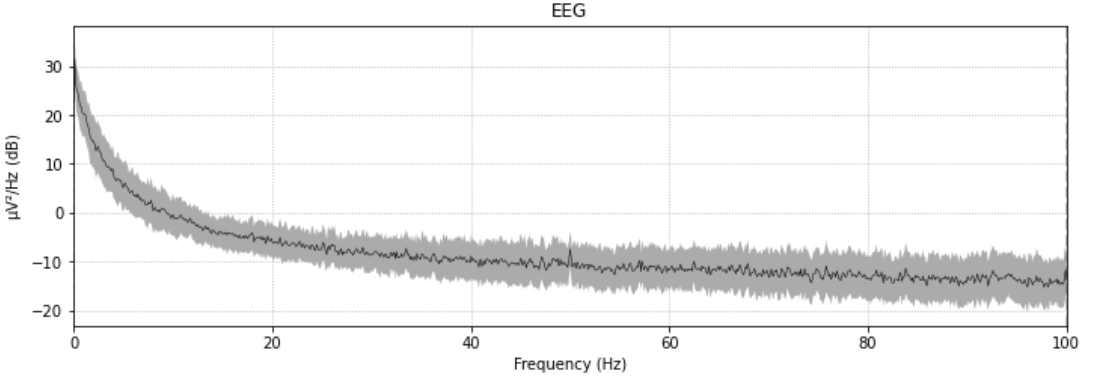
</div>


<div class='alert alert-warning'>
    <b>ToDo</b> (2 Punkte): Verwendet die `plot_psd()` Funktion (welche im Hintergrund die Fourier Transformation durchführt) um das Power Spektrum euer Daten zu berechnen, und gebt verschiedene Werte für `fmin` und `fmax` ein (niedrigste und höchste Frequenz). Vergleicht euer Spektrum mit dem obigen Beispiel und schreibt in euer Protokoll, wenn etwas nicht übereinstimmt (denkt daran: das obige Spektrum is ein mittelwert aus allen 24 Kanälen).
</div>

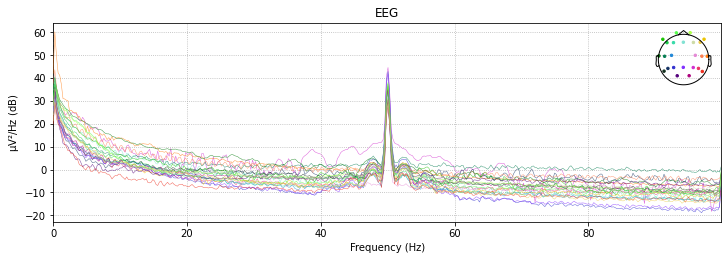

In [6]:
raw.plot_psd(fmin=0, fmax=100)
plt.show()

### 5) Preprocessing
Die mit der EEG Kappe gemessene Aktivität ist leider nicht reine Gehirnaktivität. Da die Elektroden in der Kappe sehr sensitiv sind nehmen sie auch jede andere Veränderung von elektrischem Potenzial wahr. 
Wir werden die folgenden Rauschfaktoren Schritt für Schritt aus dem Signal entfernen:

5.1) Vorbereitungen

5.2) Kanäle mit unzreichendem Signal

5.3) Augenblinzeln, Herzschlag und andere Muskelstörfaktoren

5.4) Stromleitungen

#### 5.1) Vorbereitungen

Führt erst ein Downsampling der Datendurch, so reduziert ihr die Datenpunkte - dann geht das Bearbeiten schneller!

In [7]:
resample_freq = 200
_ = raw.resample(resample_freq)

Unser Experiment besteht aus zwei Teilen: dem passiven Teil in dem ihr euren Blick auf das Kreuz fixiert habt, und dem aktiven Teil in dem ihr Zahlen zusammen addiert habt. Unterteilt die Daten in diese beiden Abschnitte - Passiv und Aktiv! Die Variablen die auf die jeweiligen Daten verweisen heißen ab jetzt ```raw_passive``` (für das passive Datenset) und ```raw_active``` (für das aktive Datenset).

Lösche außerdem die ersten 10 Sekunden, da TeilnehmerInnen Zeit brauchen um ruhig zu sein. 

In [8]:
raw_passive, raw_active = split_dataset(raw)

# Lösche die ersten und letzten 10 sekunden, da die Teilnehmer in der Zeit ihren Blick auf das Fixierungs-Kreuz gerichtet haben
start_time = 10
end_time = 290
_ = raw_passive.crop(tmin=start_time, tmax=end_time)
_ = raw_active.crop(tmin=start_time, tmax=end_time)

Datenset erfolgreich geteilt!


#### 5.2) Baseline Correction
Manche Kanäle\Elektroden weisen durch Bewegung oder Zustand der Kopfhaut (e.g. durch Schwitzen) unterschiedliche Hintergrundaktivität auf, worduch die Signale auf unterschiedlichem Grundlevel liegen (auch baseline genannt). Wir wollen sie auf die selbe Baseline bringen. Verwende hierzu die Funktion `detrend_baselines()`.

Beispiel:

<div>
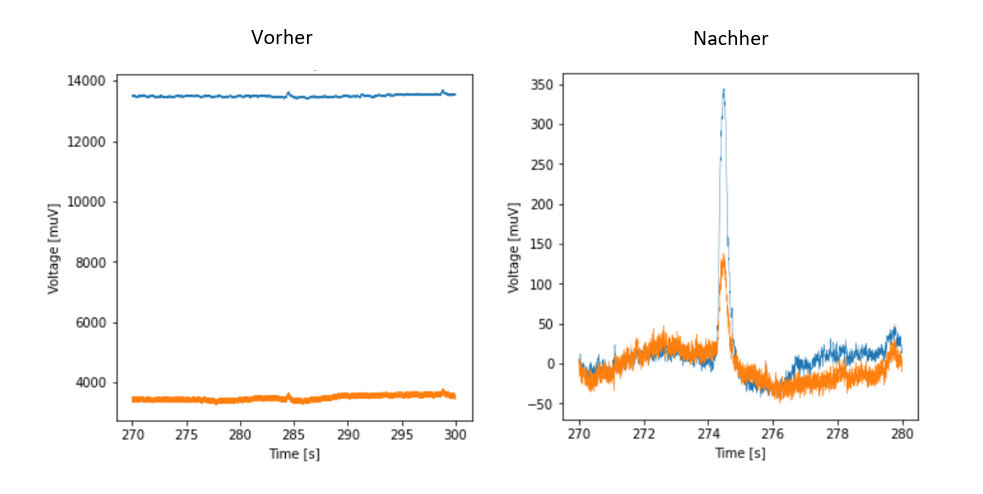
</div>



In [9]:
# Verwende die Funktion "detrend_baselines()" um die Aktivität um die Baseline um die 0 mV zu bringen
detrend_baselines(raw_passive)
detrend_baselines(raw_active)

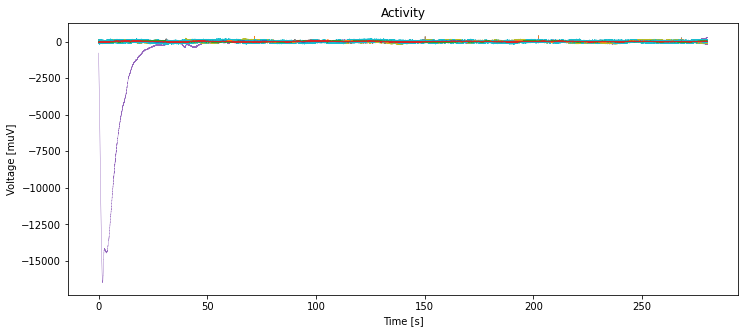

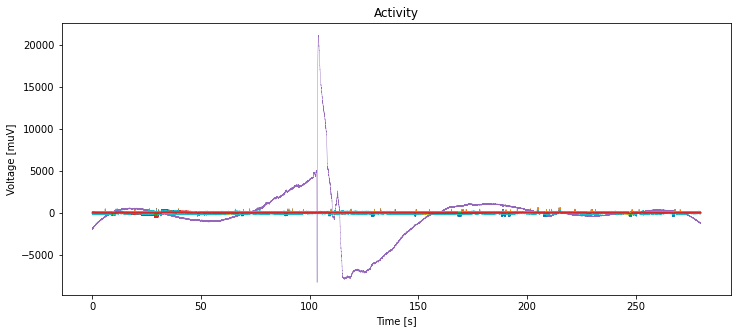

In [10]:
# Schaue dir an wie die Daten nach dem Verschieben der Baseline aussehen
plot_signal(raw_passive, electrodes=range(24))
plot_signal(raw_active, electrodes=range(24))

<div class='alert alert-success'>
    <b>Tipp</b>: Die Signale aller Kanäle liegen nun alle ungefähr auf dem selben Level (um 0µV). Somit könnt ihr jetzt ganz einfach sehen ob es einen oder mehrere Kanäle gibt die stark über das Grundlevel hinaus fluktuieren. Findet heraus welche Kanäle es sind und schreibt sie auf. 
</div>

#### 5.3) Kanäle mit unzreichendem Signal behandeln

Es ist möglich, dass einige Elektroden/Kanäle die Gehirnaktivität nicht richtig messen konnten und unbrauchbar sind - bei Trockenelektroden ist es normal, dass dies circa 20% der Kanäle sind. Wir müssen herausfinden welche Kanäle betroffen sind, um sie aus unserem Datenset zu entfernen. Dafür könnt ihr die Funktion `detect_bad_channels()` verwenden. Bei dieser Methode wird die Aktivität eines Kanals durch seine Nachbarkanäle vorhergesagt. Diese Vorhersage wird mit der echten Aktivität verglichen. Einen Kanal mit schlechtem Signal erkennt man daran, dass dieser auf Grund von vielen Störfaktoren nicht vorhergesagt werden kann.

In [11]:
detect_bad_channels(raw_passive)
detect_bad_channels(raw_active)

bad channels: ['T7']
bad channels: ['T7']


<div class='alert alert-warning'>
    <b>ToDo</b> (3 Punkte): Notiere welche Kanäle detektiert wurden und schaue ob diese mit den Kanälen übereinstimmen, die euch während der Datenerhebung bereits als unzureichend aufgefallen sind. Alle Elektroden, die ihr aufgeschrieben habt sollten nun entfernt werden. Gebt dafür dem Programm durch, um welche Kanäle es sich handelt. Fülle dazu die Liste mit den Punkten <tt>[..., ...]</tt> aus.
    
Beispiel: Tippe <tt>bad_channels_passive = ['F7', 'P10']</tt> um Elektroden F7 um P10 zu entfernen. Denkt daran: es ist  üblich das 20% aller Elektroden wegen schlechtem Signal entfernt werden müssen!
</div>

In [12]:
bad_channels_passive = ['T7', 'P4', 'F8', 'T10', 'P7']
bad_channels_active = ['T7', 'P4', 'F8', 'T10', 'P7']

In [13]:
# Entferne die Elektroden 
raw_passive_elect = remove_bad_channels(bad_channels_passive, raw_passive)
raw_active_elect = remove_bad_channels(bad_channels_active, raw_active)

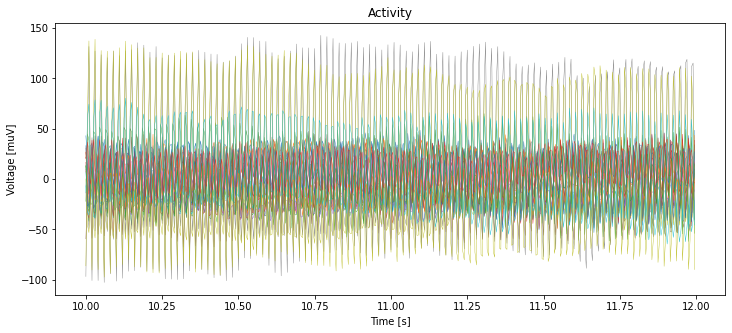

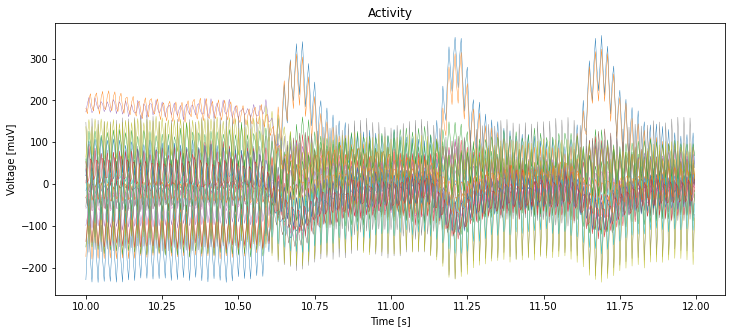

In [14]:
plot_signal(raw_passive_elect, start=10, end=12, electrodes=range(24))
plot_signal(raw_active_elect, start=10, end=12, electrodes=range(24))

#### 5.4) Störungen durch Stromleitungen
Beim Betrachten des Power Density Spectrums ist euch sicher ein starke Spitze um 50Hz aufgefallen. Das sind die Wechselstromleitungen die von den EEG Elektroden aufgezeichnet werden. Damit wir dieses Signal loswerden können und dabei möglichst wenig der gemessenen Gehirnaktivität löschen, verwenden wir den sogenannten **ZapLine Algorithmus**. Dieser wurde in der Funktion `filter_line_power()` implementiert.

<div class='alert alert-warning'>
    <b>ToDo</b> (2 Punkte): Verwendet die Funktion <tt>filter_line_power()</tt>, um das Signal zu filtern. Passe den Parameter <tt>filter_stärke</tt> an, jenach Stärke des Störsignals. Je höher der Wert desto stärker die Filter-Wirkung. Ein zu starker Wert kann die Daten allerding verzerren.. findet also den passenden Wert indem ihr euch das Power Spektrum nach dem Filtern direkt anschaut und prüft ob das 50Hz Artefakt wirklich verschwunden ist. 
</div> 

In [15]:
# Verwende "dss_line()" für das "passive" Datenset ...
raw_passive_zapline = filter_line_power(raw_passive_elect, filter_stärke=5)

# ... und für das "aktive"
raw_active_zapline = filter_line_power(raw_active_elect, filter_stärke=5)

Filtern mit Stärke 5 erfolgreich!
Filtern mit Stärke 5 erfolgreich!


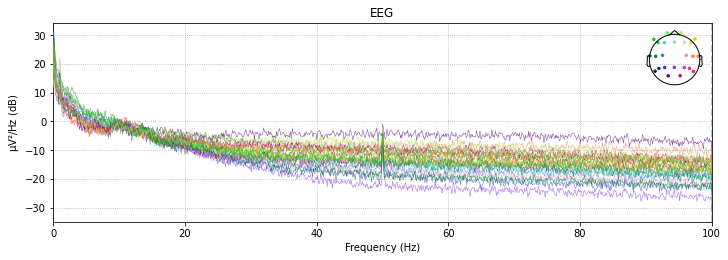

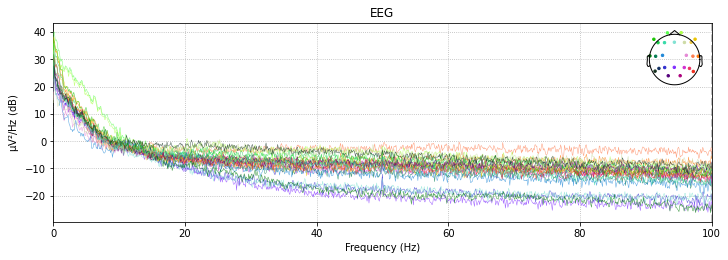

In [16]:
# Kontrolliere das Ergebnis indem du das "neue" Power Spectrum plottest. Falls du noch einen Peak bei 50Hz siest, 
# erhöhe den Wert für "nremove" in der "dss_line()" Funktion
raw_passive_zapline.plot_psd(0, 100)
plt.show()

raw_active_zapline.plot_psd(0, 100)
plt.show()

In [17]:
# Filtere außerdem die 0.5Hz Leitung aus dem Signal
raw_passive_filtered = raw_passive_zapline.copy()
_ = raw_passive_filtered.filter(l_freq=1, h_freq=None)
raw_active_filtered = raw_active_zapline.copy()
_ = raw_active_filtered.filter(l_freq=1, h_freq=None)

#### 5.4) Augenblinzeln, Herzschlag und andere Muskelstörfaktoren
In diesem Abschnitt werden wir Störfaktoren wie Augenblinzeln und den Herzschlag aufspüren, wofür wir die sogenannte **Independent Component Analysis (ICA)** verwenden werden. Diese Analysemethode macht es möglich individuelle Störfaktoren die auf verschiedene Kanäle verteilt sind aufzuspüren.

In [18]:
# Die Ausführung dieser Funktion kann etwas dauern 
raw_passive_cleaned = apply_ica(raw_passive_filtered)
raw_active_cleaned = apply_ica(raw_active_filtered)

Entfernen ICA Komponenten ['eye blink' 'eye blink'] erfolgreich!
Entfernen ICA Komponenten ['eye blink' 'eye blink' 'muscle artifact'] erfolgreich!


Betrachtet die Daten noch einmal nach dem ihr die Preprocessing Schritte durchgeführt habt. Was hat sich verändert? 

Abgebildete Elektroden: ['F7', 'Fz', 'F4']


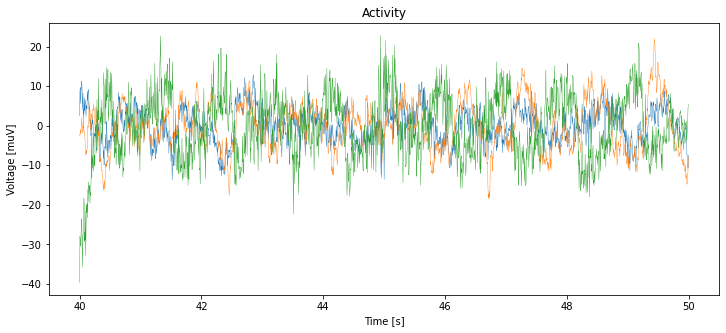

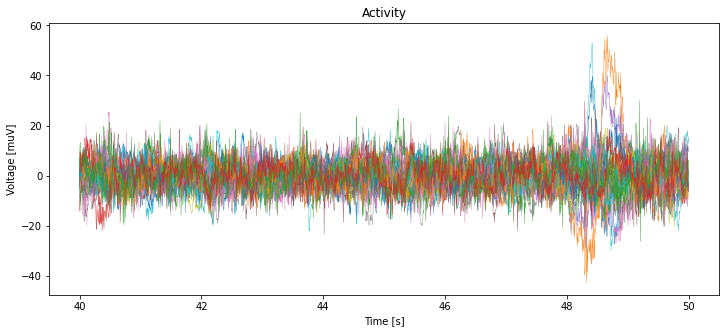

In [19]:
plot_signal(raw_passive_cleaned, start=40, end=50, electrodes=[3,5,6])
plot_signal(raw_active_cleaned, start=40, end=50, electrodes=range(24))

### 7) Berechnung der Energie im aktiven und passiven Zustand

Glückwunsch! Ihr habt eure Daten Erfolgreich gereinigt, sodass wir sie endlich für die Analyse verwenden können! 

Unser Ziel ist es, die **Energie** für das passive (auf das Fixierungskreuz fokussieren) und das aktive (Matheaufgabe lösen) Experiment vergleichen. Dafür brauchen wir das Power Spektrum, was ihr bereits im Abschnitt 4) bearbeitet habt. Für di Berechnung der Energie werden wir eine Funktion verwenden, die das Power Spektrum des jeweiligen Signals integriert. 


**WICHTIG**: Wie ihr bereits gelernt habt unterteilt man dass EEG Signal in verschiedene **Frequenz-Bänder**:
Die verschiedenen Frequenzbänder werden wie folgt unterteilt:


<div>
<img src="brainwaves.png" width="450"/>
</div>


Diese Frequenz-Bänder sind im Gehirn in verschiedenen kognitiven Zuständen unterschiedlich ausgeprägt! 


- **Alpha-Band**: Stark ausgeprägt (hohe Power), wenn sich die gemessene Person in einem ruhenden Zustand befindet, keine Aufgabe hat oder sogar die Augen schließt.
- **Gamma-Band**: Ausgeprägt (hohe Power), wenn sich die gemessene Person konzentriert, zum Beipiel auf eine Aufgabe fokussiert ist. 


<div class='alert alert-warning'>
    <b>ToDo</b> (2 Punkt): Verwendet die Funktion <tt>compare_energy_plot()</tt> um die Energie der aktiven und passiven Session für das <b>Alpha-Band</b> und das <b>Gamma-Band</b> zu vergleichen. War für ein Ergebnis erwartet ihr? Stimmen eure Erwartungen mit eurem Ergebnis überein? 
</div> 

<div class='alert alert-success'>
    <b>Tipp</b>: Für das gesamte Frequenzspektrum würde ich es wie folgt eingeben: <tt>frequeny_band = [0,100]</tt>. Für das Alpha- und Gamma-Band müsst ihr also nur die Zahlen jeweils anpassen (siehe Abbilung)!
</div>

Energie im passiven Zustand: 3.106447988866939e-12
Energie   im aktiven Zustand: 2.2097680659186344e-12


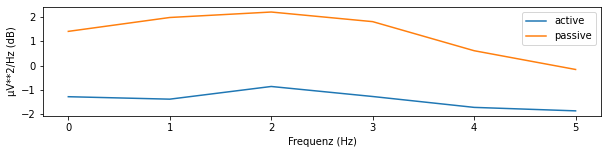

In [20]:
# Vergleiche die Power im Alpha-Band
compare_energy_plot(raw_passive_cleaned, raw_active_cleaned, frequency_band=[8, 13])

Energie im passiven Zustand: 5.089031540702859e-12
Energie   im aktiven Zustand: 7.713526978992414e-12


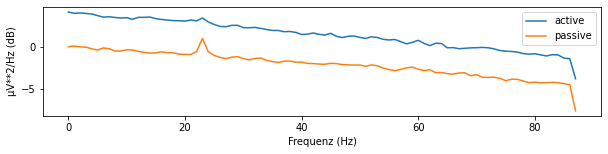

In [21]:
# Vergleiche die Power im Gamma-Band
compare_energy_plot(raw_passive_cleaned, raw_active_cleaned, frequency_band=[32, 100])

Energie im passiven Zustand: 2.9027818737088404e-11
Energie   im aktiven Zustand: 3.0580047808020486e-11


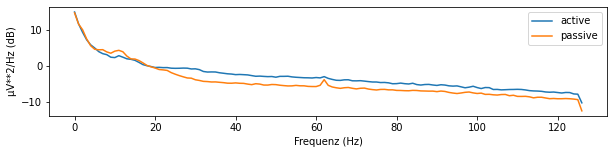

In [22]:
# Power des gesamten Frequenzbereichs
compare_energy_plot(raw_passive_cleaned, raw_active_cleaned, frequency_band=[1, 100])

### 7) Topographie
Als letztes wollen wir uns anschauen wie die Frequenzen die wir uns im Power Spektrum (siehe Abschnitt **4) Frequenz Power Spektrum**) über das Gehirn verteilt sind. Die Elektroden sind so auf der EEG Kappe verteilt, dass sie verschiedene Bereiche des Gehirns messen können. Da wir im obigen Schritt (Abschnitt **Montage Mapping**) die Elektrodenposition bereits an die gemessenen Daten angeknüpft haben, können wir die Aktivität nun für die ganze EEG Kappe grafisch darstellen.



<div class='alert alert-warning'>
    <b>ToDo</b> (1 Punkt): Erstellt eine Topographie Abbildung des Alpha-Frequenzbandes. Diese Abbildung wird euch zeigen in welchen Teilen des Gehirns die Alpha-Frequenz am stärsten vorkommt. 
</div> 

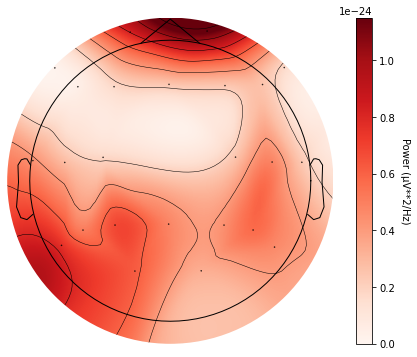

In [23]:
frequency_band_topography(raw_passive_cleaned, frequeny_band=[8,13])

In [24]:
#%matplotlib notebook 

In [25]:
evoked = mne.EvokedArray(np.array(raw_passive_ica.get_data()), raw_passive_filtered.info)
times = np.arange(1, 250, 1)
evoked.animate_topomap(times=times, ch_type="eeg", frame_rate=2, blit=False)

NameError: name 'raw_passive_ica' is not defined

In [ ]:
compare_amplitude_topography(raw_passive_ica, raw_active_ica, frequency_band=[8, 13])

In [ ]:
compare_power_topography(raw_passive_ica, raw_active_ica, frequency_band=[8,12])